In [1]:
import numpy as np
import torch
from torch import nn
import os
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pickle
import librosa
from IPython.display import Audio
from importlib import reload

from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor

seed_everything(42)

/home/soroosh/projects/general_env/lib/python3.8/site-packages/pytorch_lightning/metrics/__init__.py:43: LightningDeprecationWarning: `pytorch_lightning.metrics.*` module has been renamed to `torchmetrics.*` and split off to its own package (https://github.com/PyTorchLightning/metrics) since v1.3 and will be removed in v1.5
  rank_zero_deprecation(
Global seed set to 42


42

## data

In [2]:
alphabet = list(pickle.load(open('data/alphabet.pkl', 'rb')))
len(alphabet)

33

In [3]:
from src import TextProcessor, AudioProcessor

text_processor = TextProcessor(alphabet)
audio_processor = AudioProcessor(
    sr=22050, ref_level_db=20, n_fft=2048, n_mels=80, hop_length=1024, window='hann'
)

In [58]:
from src import TTSDataset, get_dataloader


# mel_path = '/media/data/soroosh/dataset/tts/persian-tts/mels/'

train_ds = TTSDataset(
    'data/persian-tts-train.json', 
#     'data/train.json',
    audio_processor, text_processor, 
    div_steps=1, 
    use_phonemes=False, 
    precompute_mels=False, 
#     mel_path=mel_path, 
)
val_ds = TTSDataset(
    'data/persian-tts-test.json', 
#     'data/val.json',
    audio_processor, text_processor, 
    div_steps=1, 
    use_phonemes=False, 
    precompute_mels=False, 
#     mel_path=mel_path, 
)
print(f'Training data has {len(train_ds)} samples with a total of {train_ds.meta.duration.sum() // 3600} hours audio.')
print(f'Validation data has {len(val_ds)} samples with a total of {val_ds.meta.duration.sum() // 3600} hours audio.')

Training data has 4907 samples with a total of 19.0 hours audio.
Validation data has 1231 samples with a total of 5.0 hours audio.


In [59]:
tl = get_dataloader(train_ds, batch_size=4, n_jobs=4)
vl = get_dataloader(val_ds, batch_size=4, n_jobs=4)

In [61]:
b = next(iter(vl))
for a in b:
    print(a.shape, a.dtype)

torch.Size([4, 399]) torch.int64
torch.Size([4]) torch.int64
torch.Size([4, 1040, 80]) torch.float32
torch.Size([4]) torch.int64


## model

In [18]:
config = {
    'encoder': {
        'n_vocab' : text_processor.n_vocab,
        'd_emb' : 256, 
        'd_hidden' : 256, 
        'n_head' : 8, 
        'd_inner' : 512, 
        'n_encoder_layers' : 3, 
        'n_prenet_layers' : 3, 
        'kernel' : 5, 
        'dropout' : 0.2
    },
    'decoder': {
        'n_mel' : 80, 
        'd_hidden' : 256, 
        'n_head' : 8, 
        'd_inner' : 512, 
        'outputs_per_step' : 1,
        'n_decoder_layers' : 3, 
        'n_postnet_layers' : 3, 
        'kernel' : 5, 
        'dropout' : 0.2
    },
    'lr' : 1e-4
}

config

{'encoder': {'n_vocab': 36,
  'd_emb': 256,
  'd_hidden': 256,
  'n_head': 8,
  'd_inner': 512,
  'n_encoder_layers': 3,
  'n_prenet_layers': 3,
  'kernel': 5,
  'dropout': 0.2},
 'decoder': {'n_mel': 80,
  'd_hidden': 256,
  'n_head': 8,
  'd_inner': 512,
  'outputs_per_step': 1,
  'n_decoder_layers': 3,
  'n_postnet_layers': 3,
  'kernel': 5,
  'dropout': 0.2},
 'lr': 0.0001}

In [77]:
import src.modules
reload(src.modules)
import src.model
reload(src.model)
import src
reload(src)
from src import TransformerTTS

model = TransformerTTS(config, audio_processor, text_processor)
model.count_parameters()

5807523

In [62]:
model.step(b, 0)

tensor(2.4807)

In [10]:
# fig = model.make_attn_figure(attn[0])
# fig = model.make_spec_figure(linear_outputs[0])

## trainer

In [63]:
logger = TensorBoardLogger(save_dir='logs/', name='persian-tts-l1l2')
lr_logger = LearningRateMonitor(logging_interval='step')
checkpoint = ModelCheckpoint(
    dirpath='weights/persian-tts/', 
    filename='{epoch}-{val_loss:.2f}', 
    monitor='train_loss',
    save_top_k=5, 
    period=1
)

trainer = Trainer(
#     benchmark=True, 
    gpus=0, 
    accumulate_grad_batches=8,
    logger=logger, 
    max_epochs=10,
    callbacks=[checkpoint, lr_logger]
)

/home/soroosh/projects/general_env/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:396: LightningDeprecationWarning: Argument `period` in `ModelCheckpoint` is deprecated in v1.3 and will be removed in v1.5. Please use `every_n_val_epochs` instead.
  rank_zero_deprecation(
GPU available: True, used: False
TPU available: False, using: 0 TPU cores


In [64]:
trainer.fit(model, tl, vl)


  | Name    | Type    | Params
------------------------------------
0 | l1      | L1Loss  | 0     
1 | l2      | MSELoss | 0     
2 | encoder | Encoder | 2.6 M 
3 | decoder | Decoder | 3.2 M 
------------------------------------
5.8 M     Trainable params
0         Non-trainable params
5.8 M     Total params
23.230    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: 0it [00:00, ?it/s]

In [65]:
trainer.save_checkpoint('weights/persian-tts/last.ckpt')

## synthesis

In [90]:
import src.model
reload(src.model)
import src
reload(src)
from src import TransformerTTS

gen_model = TransformerTTS.load_from_checkpoint('weights/persian-tts/last.ckpt', config=config, audio_processor=audio_processor, text_processor=text_processor)

In [92]:
text = 'خدایا'
mel = gen_model.synthesize(text, max_len=100)
mel.shape

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([80, 101])

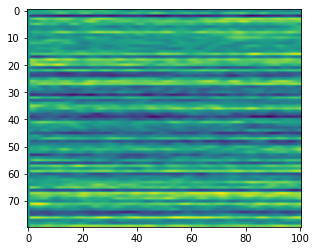

In [94]:
plt.imshow(mel)

In [23]:
y = audio_processor.spec_to_audio(linear_outputs[0].detach().cpu().numpy().T)

In [ ]:
print(y.shape)
Audio(y, rate=22050)

(1028096,)
